# Setup

In [ ]:
# !git clone https://github.com/Sopralapanca/medium-skill-based-agents.git
# %cd /content/medium-skill-based-agents
# !ls

In [ ]:
!uv --version

uv 0.9.18 (0cee76417 2025-12-16)


In [ ]:
# ! yes | pip uninstall gym

"yes" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [ ]:
# !uv pip install -r pyproject.toml

^C


   Updating https://github.com/Sopralapanca/atari-representation-learning.git (HEAD)
    Updated https://github.com/Sopralapanca/atari-representation-learning.git (eb0a9270dfd71cf19632882765f8945266e6428c)
Resolved 115 packages in 10.94s
   Building atariari @ git+https://github.com/Sopralapanca/atari-representation-learning.git@eb0a9270dfd71cf19632882765f8945266e6428c
      Built atariari @ git+https://github.com/Sopralapanca/atari-representation-learning.git@eb0a9270dfd71cf19632882765f8945266e6428c
Prepared 1 package in 1.89s
Uninstalled 1 package in 24ms
Installed 1 package in 36ms
 - atariari==0.0.1 (from git+https://github.com/Sopralapanca/atari-representation-learning.git@6ef260a81915eee0c0d1bd99da70e80300799c7b)
 + atariari==0.0.1 (from git+https://github.com/Sopralapanca/atari-representation-learning.git@eb0a9270dfd71cf19632882765f8945266e6428c)


In [ ]:
# !python create_dataset.py

In [ ]:
# !python train_vos.py
# !python train_vok.py
# !python train_usr.py

Import the required packages, build the environment and test if it works

c:\Users\giaco\VSCode Projects\medium-articles\skill-based-agents\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


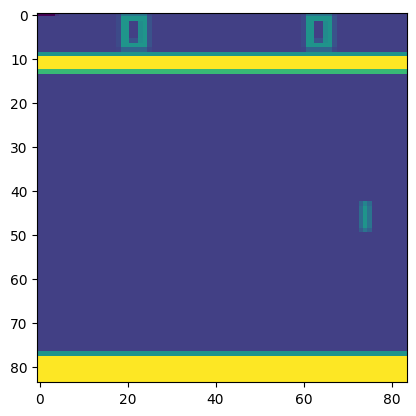

In [1]:
# general imports
import torch
import yaml
import numpy as np
import random
import os

# training imports
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage

import matplotlib.pyplot as plt

import tensorflow as tf

# IMPORTANT - REGISTER THE ENVIRONMENTS
import gymnasium as gym
import ale_py 
gym.register_envs(ale_py)

# Load config
_config_path = "./configs.yaml"

_config = {}
with open(_config_path, "r") as f:
    _config = yaml.safe_load(f) or {}
        

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # ignore tensorflow warnings about CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

seed = None
if seed is not None:    
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


logdir = "./tensorboard_logs"


env = _config.get("ENVS", "PongNoFrameskip-v4")[0]
with open(f'environment_configs/{env}.yaml', 'r') as file:
        environment_configuration = yaml.safe_load(file)["config"]


environment_configuration["f_ext_kwargs"]["device"] = device  #do not comment this, it is the parameter passed to the feature extractor
environment_configuration["game"] = env



vec_envs = make_atari_env(env, n_envs=environment_configuration["n_envs"], seed=seed)
vec_envs = VecFrameStack(vec_envs, n_stack=environment_configuration["n_stacks"])
vec_envs = VecTransposeImage(vec_envs)

# execute some steps with random moves
obs = vec_envs.reset()

for i in range(10):
    action = [vec_envs.action_space.sample() for _ in range(environment_configuration["n_envs"])]
    obs, rewards, dones, info = vec_envs.step(action)

# obs[0] has shape (4, 84, 84) because there are 4 stacked environments, take the first
observation = obs[0][-1]
plt.imshow(observation)
plt.show()



In [2]:
from skills.autoencoder import Autoencoder
from skills.unsupervised_state_representation import UnsupervisedStateRepresentationModel
from skills.video_object_keypoints import Transporter
from skills.video_object_segmentation import VideoObjectSegmentationModel
from utils.feature_extractors import WeightSharingAttentionExtractor

# init skills
autoencoder = Autoencoder(channels=1).to(device)

# observation has shape (32, 4, 84, 84), 
observation = obs[0][0][None, :, :] # (1, 84, 84)

usr = UnsupervisedStateRepresentationModel(observation=observation, device=device)
vok = Transporter().to(device)
vos = VideoObjectSegmentationModel(device=device)


skills = [
    usr.get_skill(device=device),
    vok.get_skill(device=device, keynet_or_encoder="encoder"),
    vok.get_skill(device=device, keynet_or_encoder="keynet"),
    vos.get_skill(device=device)
]

f_ext_kwargs = environment_configuration["f_ext_kwargs"]

environment_configuration["f_ext_name"] = "wsharing_attention_ext"
environment_configuration["f_ext_class"] = WeightSharingAttentionExtractor

f_ext_kwargs["skills"] = skills
f_ext_kwargs["features_dim"] = 256


policy_kwargs = dict(
    features_extractor_class=environment_configuration["f_ext_class"],
    features_extractor_kwargs=f_ext_kwargs,
    net_arch={
        'pi': environment_configuration["net_arch_pi"],
        'vf': environment_configuration["net_arch_vf"]
    },
    #activation_fn=th.nn.ReLU,  # use ReLU in case of multiple layers for the policy learning network
)

In [4]:
from stable_baselines3 import PPO
from rl_zoo3.utils import linear_schedule



eval_env = make_atari_env(env, n_envs=environment_configuration["n_envs"])
eval_env = VecFrameStack(eval_env, n_stack=environment_configuration["n_stacks"])
eval_env = VecTransposeImage(eval_env)


model = PPO("CnnPolicy",
            vec_envs,
            learning_rate=linear_schedule(environment_configuration["learning_rate"]),
            n_steps=128,
            n_epochs=4,
            batch_size=environment_configuration["batch_size"],
            clip_range=linear_schedule(environment_configuration["clip_range"]),
            normalize_advantage=environment_configuration["normalize"],
            ent_coef=environment_configuration["ent_coef"],
            vf_coef=environment_configuration["vf_coef"],
            policy_kwargs=policy_kwargs,
            verbose=0,
            device=device,
        )



RuntimeError: Given groups=1, weight of size [32, 1, 8, 8], expected input[1, 4, 160, 210] to have 1 channels, but got 4 channels instead

In [ ]:
run_id = "test_run_1_wsa"
gamelogs = f"{logdir}/{env}/{run_id}"
os.makedirs(gamelogs, exist_ok=True)

eval_callback = EvalCallback(
    eval_env,
    n_eval_episodes=100,
    best_model_save_path=f"./agents/{run_id}",
    log_path=gamelogs,
    eval_freq=5000 * environment_configuration["n_envs"],
    verbose=0
)

callbacks = [
    eval_callback
]

model.learn(
    environment_configuration["n_timesteps"],
    callback=callbacks
)
